In [49]:
import os
import sys , time , traceback  , itertools
import datetime as dt

from tqdm import tqdm
import warnings , ipdb
import pandas as pd
import pandas_datareader.data as web
import numpy as np

import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
import scipy.stats as scs
from arch import arch_model

import matplotlib.pyplot as plt
import matplotlib as mpl

#plt.style.use('ggplot')

import tsalib

In [2]:
%matplotlib notebook

In [3]:
warnings.filterwarnings('ignore')

In [4]:
# fb_df = (pd.read_csv('/home/vlad/data/AMZN_und.csv',parse_dates=['last'])
#          .drop_duplicates()
#         .set_index('last'))

# fb_df.head()

In [238]:
start = '2008-01-01'
end =dt.datetime.strftime(dt.datetime.strptime('2019-03-01','%Y-%m-%d') + dt.timedelta(days=22)
                     ,'%Y-%m-%d')

get_px = lambda x: web.DataReader(x, 'yahoo', start=start, end=end)

# symbols = ['SPY','TLT','MSFT']
# # raw adjusted close prices
# data = pd.DataFrame({sym:get_px(sym)['Adj Close'] for sym in symbols})

snp500 = get_px('SPY')
# log returns
lrets = np.log(snp500['Adj Close']/snp500['Adj Close'].shift(1)).dropna()

rets = 100* snp500['Adj Close'].pct_change().dropna()


snp500['vola'] = 100*(snp500.High - snp500.Low)/snp500['Adj Close']

snp500vola = pd.DataFrame(snp500.vola)

In [7]:
#TS plot diff
# tsplot(data.MSFT.shift(1))

In [8]:
#tsplot(lrets.SPY)

In [9]:
# _ = tsplot(res_tup[2].resid**2, lags=30)
#Squared residuals show autocorrelation. Let's fit a GARCH model and see how it does. 

ADF Statistic: -17.711633
p-value: 0.000000
Critical Values:
	1%: -3.436
	5%: -2.864
	10%: -2.568


<IPython.core.display.Javascript object>


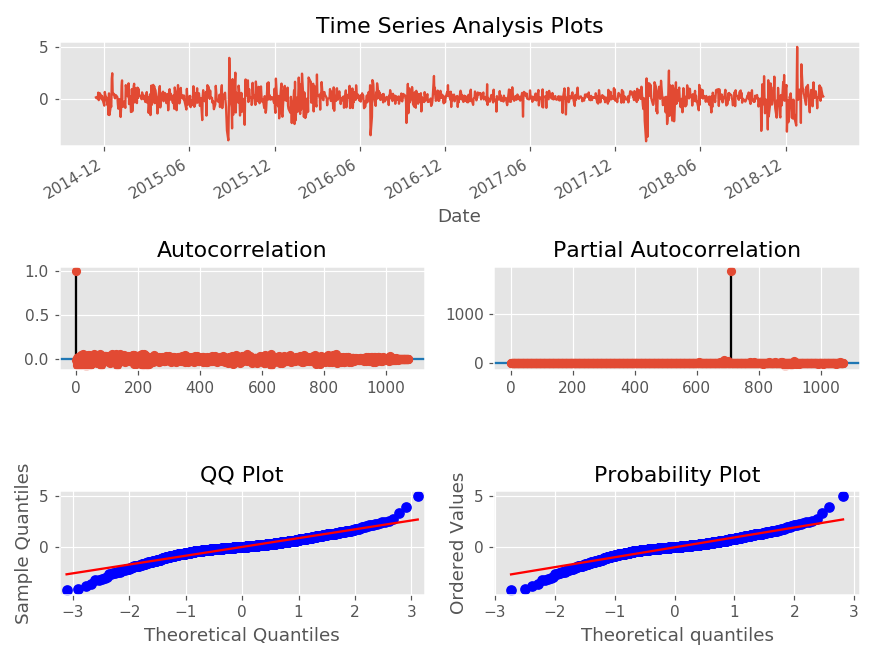

In [246]:
#fig, ax = plt.subplots(1,1)
windowLength = 1095
horizon = 22
TS = rets[-windowLength:-horizon].copy()
n=2

result = adfuller(TS)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))


tsalib.tsplot(TS);

In [215]:
# res_tup = tsalib.get_best_arma(TS)
# order = res_tup[1]
# model = res_tup[2]
# p_ = order[0] +n
# o_ = order[1]
# q_ = order[2] +n

# # res = (arch_model(model.resid, p=p_, o=o_, q=q_, dist='StudentsT')
# #                             .fit(update_freq=5, disp='off')
# #                           )


# #signal = backtest_volamodel(lTS = lrets.SPY)

Solving best ARCH model ...


100%|██████████| 16/16 [00:06<00:00,  2.35it/s]


<IPython.core.display.Javascript object>


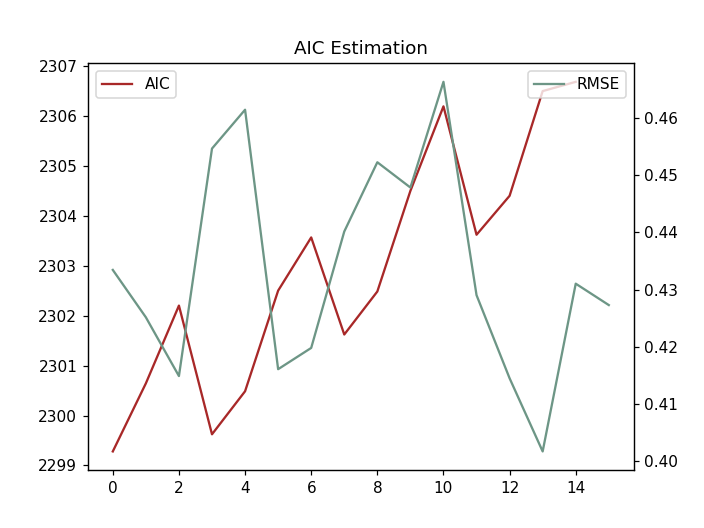

best parameters:  (4, 2) At index: 13


In [247]:
def find_arch(TS,true_variance,horizon):
    aic_d = []
    RMSE = []
    params_factor  = {'p':list(range(1,5)), 'o':list(range(1,5))}
    params_factor_list = [item for key, item  in params_factor.items()]
    params_factor_grid = list(itertools.product(*params_factor_list))
    print('Solving best ARCH model ...')
    time.sleep(1)
    for param in tqdm(params_factor_grid):
        p_ = param[0]
        q_ = param[1]
        o_ = 0
        res = (arch_model(TS, p=p_, o=o_, q=q_, dist='StudentsT',vol='GARCH')
                                .fit(update_freq=5, disp='off')
                              )
        aic_d.append(res.aic)    

        forecast  = (res.forecast(horizon=horizon, start=None, align='origin', method='simulation')
                    )
        expected_variance =  forecast.variance.iloc[-1].values
        RMSE.append(np.sqrt(np.mean(np.power(expected_variance - true_variance[-horizon:],2))))
        



    fig, ax = plt.subplots(1,1)
    title = plt.title('AIC Estimation')
    lines = ax.plot(aic_d[1:],label='AIC',color='#a82828')
    #lines[0].set_label('AIC')

    ax2 = ax.twinx()
    lines2 = ax2.plot(RMSE,label='RMSE',color='#6d9686')
    #lines2[0].set_label('RMSE')

    legend = ax.legend()
    legend2 = ax2.legend()
    combo_param = [a*b*1e3 for a,b in zip(aic_d ,RMSE)]
    best_params= params_factor_grid[(combo_param.index(min(combo_param)))]
    print('best parameters: ',best_params, 'At index:',params_factor_grid.index(best_params))
    return params_factor_grid , best_params


params_factor_grid , best_params = find_arch(TS=TS,true_variance=snp500vola.vola.values,horizon=horizon)



<IPython.core.display.Javascript object>


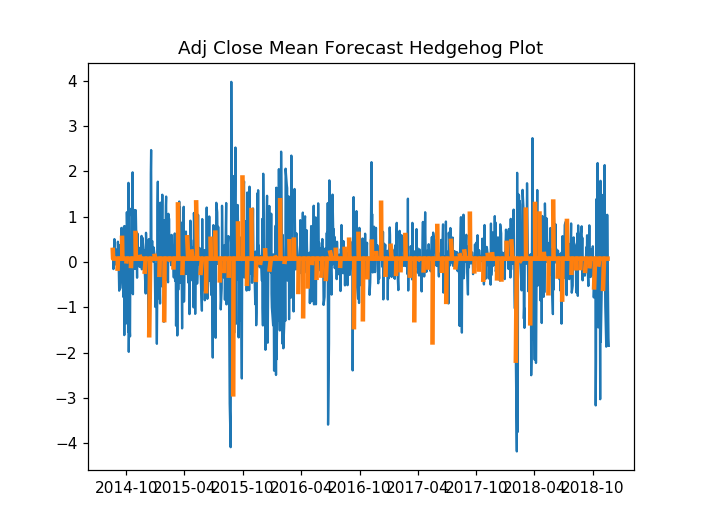

                        Constant Mean - GARCH Model Results                         
Dep. Variable:                    Adj Close   R-squared:                      -0.002
Mean Model:                   Constant Mean   Adj. R-squared:                 -0.002
Vol Model:                            GARCH   Log-Likelihood:               -1143.20
Distribution:      Standardized Student's t   AIC:                           2304.40
Method:                  Maximum Likelihood   BIC:                           2349.21
                                              No. Observations:                 1073
Date:                      Mon, Apr 01 2019   Df Residuals:                     1064
Time:                              01:15:24   Df Model:                            9
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu        

In [248]:
res_final = (arch_model(TS, p=best_params[0], o=0, q=best_params[1], dist='StudentsT',vol='GARCH')
                                .fit(update_freq=5, disp='off')
            )


forecast  = (res.forecast(horizon=horizon, start=None, align='origin', method='simulation')
            )

f = res2.hedgehog_plot(type='mean')
print(res_final)


<IPython.core.display.Javascript object>


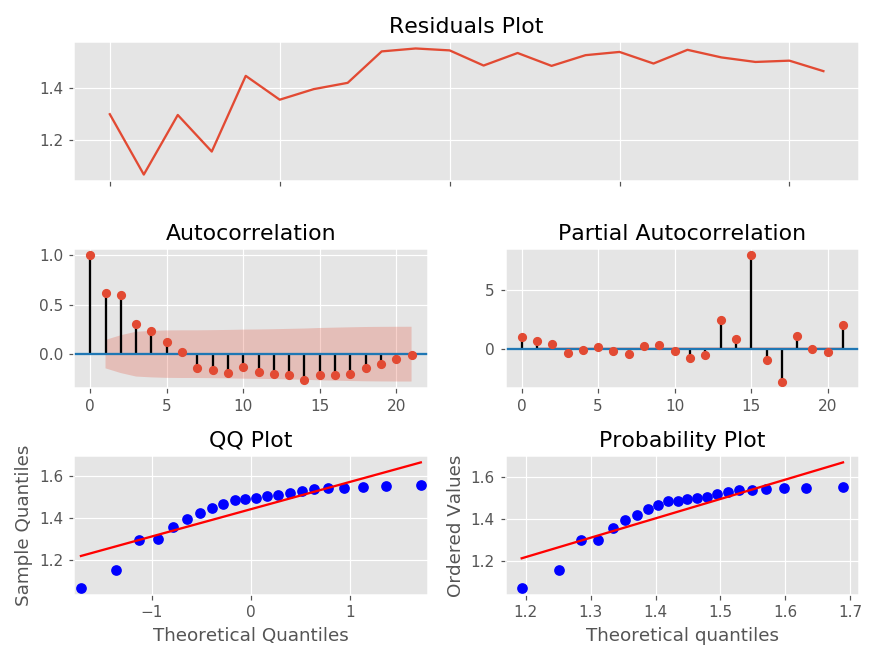

In [218]:
forecast  = (res_final.forecast(horizon=horizon, start=None, align='origin', method='simulation')
                          # .mean['h.1']
                          #.iloc[-1]              
                          )

tsalib.tsplot(forecast.residual_variance.iloc[-1],title='Residuals Plot')

#snp500vola



<IPython.core.display.Javascript object>


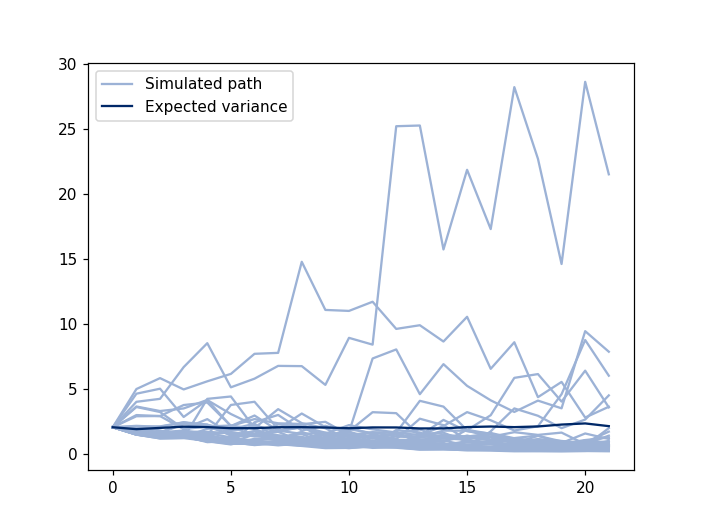

In [249]:
sims = forecast.simulations

simulated_path = sims.residual_variances[-1,:] #/100
expected_variance =  forecast.variance.iloc[-1].values #/100
true_variance = snp500vola.loc[start:end].iloc[-horizon:]
#expected_means = 

dti = pd.DatetimeIndex(start=TS.index[-1] + dt.timedelta(days=1)
                                                        ,end=TS.index[-1] + dt.timedelta(days=horizon+12)
                                                        ,freq='D').to_series().dt.dayofweek

dti = dti[(dti!=5) & (dti!=6)].index

expected_variance_ts = pd.Series(expected_variance,
                                 index=true_variance.index)
                                

most_var_sim_ts = pd.Series(tsalib.variance_quantiles(simulated_path,prc=0.51),
                                 index=true_variance.index)

fig, ax = plt.subplots(1,1)
lines = plt.plot(simulated_path[::30].T, color='#9cb2d6')
lines[0].set_label('Simulated path')
line = plt.plot(expected_variance, color='#002868')
line[0].set_label('Expected variance')
legend = plt.legend()


<IPython.core.display.Javascript object>


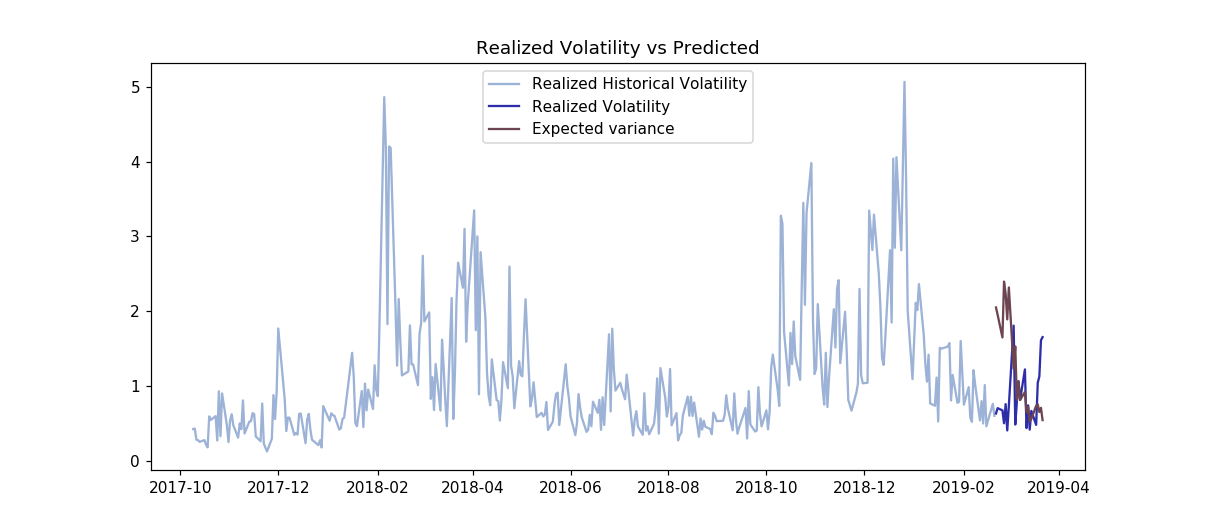

In [250]:
fig, ax = plt.subplots(1,1)
lines = plt.plot(snp500vola.loc[start:end].iloc[-365:-horizon], color='#9cb2d6')
lines[0].set_label('Realized Historical Volatility')

line = plt.plot(true_variance, color='#2e2eaa')
line[0].set_label('Realized Volatility')

#line = plt.plot(expected_variance_ts, color='#6d4551')
line = plt.plot(most_var_sim_ts, color='#6d4551')
line[0].set_label('Expected variance')


plt.title('Realized Volatility vs Predicted')
legend = plt.legend()

In [251]:
np500_true = snp500.loc[most_var_sim_ts.index]
expect_m_var = np.sum([np.power(x-most_var_sim_ts.values.mean(),2) for x in most_var_sim_ts.values]) *100/ np500_true.iloc[0,1]
#true_m_var = np.sum([np.power(x-true_variance.vola.values.mean(),2) for x in true_variance.vola.values]) *100/ np500_true.iloc[0,1]
true_m_var =  np.abs((np500_true.iloc[0,1] - np500_true.iloc[-1,0])) *100/ np500_true.iloc[0,1]
print('Expected monthly variance:',expect_m_var,'\nTrue monthly variance:',true_m_var)

Expected monthly variance: 3.255611095043253 
True monthly variance: 2.695850018060973
